# Capstone Project : Part.2

In [1]:
from feature_selector import FeatureSelector
from sklearn.preprocessing import Imputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

## 1. FeatureSelector

##### application_train / test

In [2]:
app_train = pd.read_csv('data_set/application_train.csv')
app_test = pd.read_csv('data_set/application_test.csv')
app_label = app_train['TARGET']

fs = FeatureSelector(data = app_train.drop('TARGET', axis= 1) , labels= app_label)

Using the FeatureSelector class for preprocessing and selecting features to remove from a dataset. This class has five methods for finding features to remove:

* Find columns with a missing fraction greater than a specified threshold
* Find features with only a single unique value
* Find collinear features as identified by a correlation coefficient greater than a specified value
* Find features with 0.0 importance from a gradient boosting machine
* Find features that do not contribute to a specified cumulative feature importance from the gradient boosting machine

FeatureSelector Github: https://github.com/WillKoehrsen/feature-selector

In [3]:
# Missing values
fs.identify_all(selection_params= {'missing_threshold': 0.6, 'correlation_threshold': 0.98, 
                                    'task': 'classification', 'eval_metric': 'auc', 
                                     'cumulative_importance': 0.99})

17 features with greater than 0.60 missing values.

0 features with a single unique value.

20 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[228]	valid_0's auc: 0.75974
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[255]	valid_0's auc: 0.754021
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[221]	valid_0's auc: 0.753888
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[579]	valid_0's auc: 0.761197
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[351]	valid_0's auc: 0.760246
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[401]	valid_0's auc: 0.756165
Training until validation scores don't improve

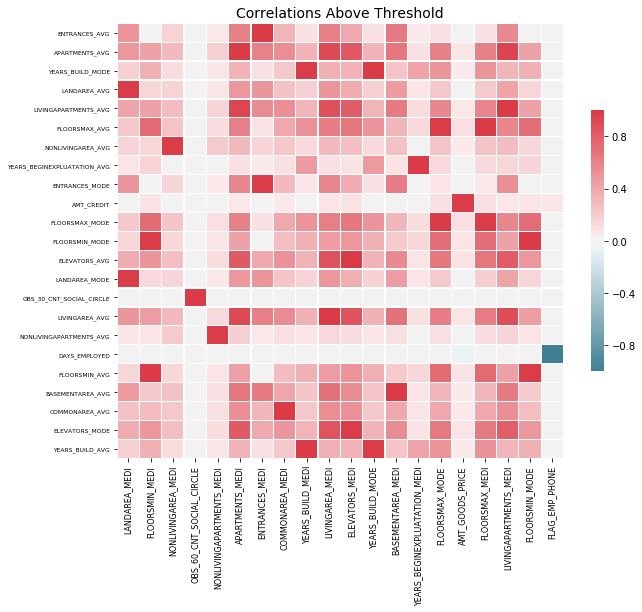

In [4]:
# Plot all of the correlations in the data with a heatmap. these features which will be dropped are on the x-axis

fs.plot_collinear()

There are 20 features with a correlation threshold greater than 0.98.

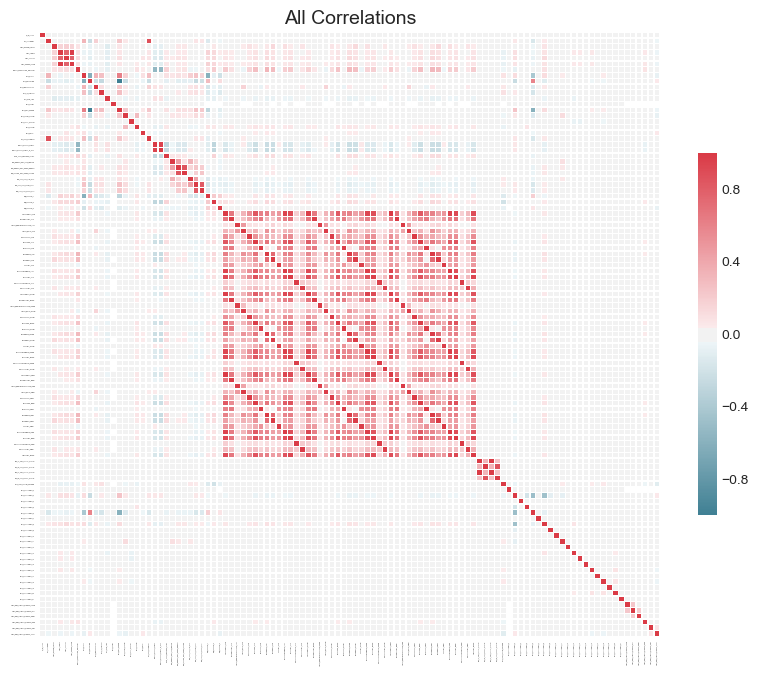

In [7]:
# Plot all of the correlations in the data

fs.plot_collinear(plot_all=True)

In [13]:
fs.record_collinear

,corr_feature,corr_value,drop_feature
0,AMT_CREDIT,0.986968,AMT_GOODS_PRICE
1,DAYS_EMPLOYED,-0.999755,FLAG_EMP_PHONE
2,YEARS_BUILD_AVG,0.989444,YEARS_BUILD_MODE
3,FLOORSMAX_AVG,0.985689,FLOORSMAX_MODE
4,FLOORSMIN_AVG,0.985875,FLOORSMIN_MODE
5,APARTMENTS_AVG,0.995081,APARTMENTS_MEDI
6,BASEMENTAREA_AVG,0.994317,BASEMENTAREA_MEDI
7,YEARS_BEGINEXPLUATATION_AVG,0.993825,YEARS_BEGINEXPLUATATION_MEDI
8,YEARS_BUILD_AVG,0.998495,YEARS_BUILD_MEDI
9,YEARS_BUILD_MODE,0.989463,YEARS_BUILD_MEDI


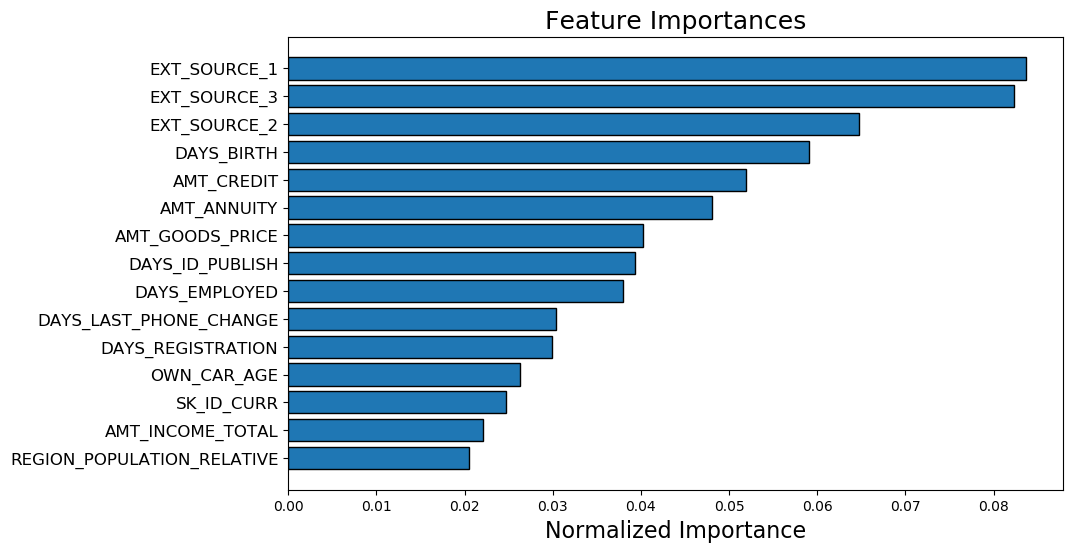

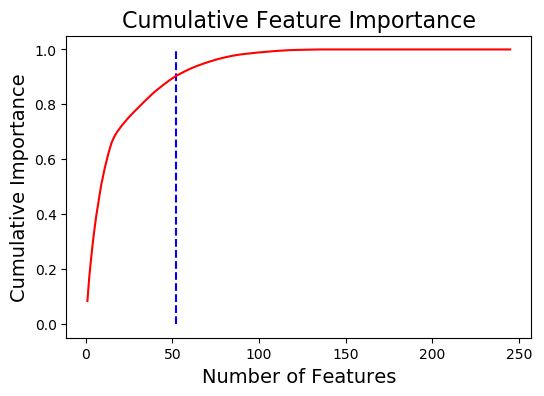

52 features required for 0.90 of cumulative importance


In [6]:
# Plot feature importance

fs.plot_feature_importances(threshold= 0.9)

In [7]:
#  LIst of features with zero importance.

zero_importance_features = fs.ops['zero_importance']

## 2. Preprocessing for Benchmark model

In [11]:
X_train = app_train.drop('TARGET', axis = 1).copy()
X_test = app_test.copy()
y_train = app_label.copy()

print('Training data shape: ', X_train.shape, type(X_train))
print('Testing data shape: ', X_test.shape, type(X_test))
print('Labels shape: ', y_train.shape, type(y_train))

('Training data shape: ', (307511, 121), <class 'pandas.core.frame.DataFrame'>)
('Testing data shape: ', (48744, 121), <class 'pandas.core.frame.DataFrame'>)
('Labels shape: ', (307511,), <class 'pandas.core.series.Series'>)


In [9]:
# One-hot encoding of categorical variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align the training and testing data, keep only columns present in both dataframes
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# Median imputation of missing values
imputer = Imputer(strategy='median')

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Converting y_test to a numpy array
y_train = y_train.as_matrix()

print(type(X_train), type(y_train))
print(type(X_test))

(<type 'numpy.ndarray'>, <type 'numpy.ndarray'>)
<type 'numpy.ndarray'>


## 3. benchmark_model

In [10]:
from sklearn.linear_model import LogisticRegression

# Initialize and fit the model
benchmark_model = LogisticRegression(C = 0.0001)
benchmark_model.fit(X_train, y_train)

# Predict
y_pred = benchmark_model.predict_proba(X_test)[: , 1]

# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = y_pred

submit.head()

# Memory management
del X_train, X_test, y_pred, app_label, y_train

In [ ]:
submit.to_csv('benchmark_model.csv', index = False)

The Logistic regression base model's scored 0.623.

## 4. Feature Engineering

### 4-1. application_train / test

##### train data

In [12]:
new_app_train =  app_train.copy()
new_app_test = app_test.copy()

# Client's the credit amt of income (%)
new_app_train['CREDIT_INCOME_PERCENT'] = new_app_train['AMT_CREDIT'] / new_app_train['AMT_INCOME_TOTAL']

# Client's the loan annuity of income (%)
new_app_train['ANNUITY_INCOME_PERCENT'] = new_app_train['AMT_ANNUITY'] / new_app_train['AMT_INCOME_TOTAL']

# Client's the length of the payment in months
new_app_train['CREDIT_TERM'] = new_app_train['AMT_ANNUITY'] / new_app_train['AMT_CREDIT']

# Clinet's the age percent of the days employed 
new_app_train['DAYS_EMPLOYED_PERCENT'] = new_app_train['DAYS_EMPLOYED'] / new_app_train['DAYS_BIRTH']

# Replace the outlier with nan
new_app_train['DAYS_EMPLOYED'].replace({365243 : np.nan}, inplace= True)
new_app_train['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

# Create columns : 
# Credit amount of the loan / Loan annuity
new_app_train['AMT_CREDIT_ANNUITY_RATE'] = new_app_train.AMT_CREDIT / new_app_train.AMT_ANNUITY
new_app_train['NEW_CREDIT_TO_GOODS_RATIO'] = new_app_train['AMT_CREDIT'] / new_app_train['AMT_GOODS_PRICE']

# Dropping low importance features
drop_columns = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','ORGANIZATION_TYPE' , 'EMERGENCYSTATE_MODE' ,'FLAG_DOCUMENT_5',
                'FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',  'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
                'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17',
                'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21', 'NAME_INCOME_TYPE', ]

X_train = new_app_train.drop(drop_columns, axis = 1)

# One-hot encoding of categorical variables
X_train = pd.get_dummies(X_train)

print('Training Features shape: ', X_train.shape, type(X_train))

del app_train, new_app_train

('Training Features shape: ', (307511, 165), <class 'pandas.core.frame.DataFrame'>)


In [13]:
# Client's the credit amt of income (%)
new_app_test['CREDIT_INCOME_PERCENT'] = new_app_test['AMT_CREDIT'] / new_app_test['AMT_INCOME_TOTAL']

# Client's the loan annuity of income (%)
new_app_test['ANNUITY_INCOME_PERCENT'] = new_app_test['AMT_ANNUITY'] / new_app_test['AMT_INCOME_TOTAL']

# Client's the length of the payment in months
new_app_test['CREDIT_TERM'] = new_app_test['AMT_ANNUITY'] / new_app_test['AMT_CREDIT']

# Clinet's the age percent of the days employed 
new_app_test['DAYS_EMPLOYED_PERCENT'] = new_app_test['DAYS_EMPLOYED'] / new_app_test['DAYS_BIRTH']

# Replace the outlier with nan
new_app_test['DAYS_EMPLOYED'].replace({365243 : np.nan}, inplace= True)
new_app_test['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

# Create columns : 
# Credit amount of the loan / Loan annuity
new_app_test['AMT_CREDIT_ANNUITY_RATE'] = new_app_test.AMT_CREDIT / new_app_test.AMT_ANNUITY
new_app_test['NEW_CREDIT_TO_GOODS_RATIO'] = new_app_test['AMT_CREDIT'] / new_app_test['AMT_GOODS_PRICE']

# Dropping low importance features
drop_columns = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','ORGANIZATION_TYPE' , 'EMERGENCYSTATE_MODE' ,'FLAG_DOCUMENT_5',
                'FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',  'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
                'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16','FLAG_DOCUMENT_17',
                'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21', 'NAME_INCOME_TYPE', ]

new_app_test = new_app_test.drop(drop_columns, axis = 1)

X_test = new_app_test

# One-hot encoding of categorical variables

X_test = pd.get_dummies(X_test)

print('Testing Features shape: ', X_test.shape, type(X_test))

del app_test, new_app_test

('Testing Features shape: ', (48744, 162), <class 'pandas.core.frame.DataFrame'>)


### 4-1. bureau.csv

In [30]:
bureau = pd.read_csv('data_set/bureau.csv')

In [31]:
# Split dataset to categorical data and numerical data for merge
#  Fisrt, select the categorical columns
bureau_category = pd.get_dummies(bureau.select_dtypes('object'))

# Make sure to put the identifying id on the column
bureau_category['SK_ID_CURR'] = bureau['SK_ID_CURR']

# Groupby the group var and calculate the sum and mean
bureau_category = bureau_category.groupby('SK_ID_CURR').agg(['sum', 'mean'])
    
column_names = []
    
# Iterate through the columns in level 0
for i in bureau_category.columns.levels[0]:
    # Iterate through the stats in level 1
    for status in ['count', 'count_norm']:
        # Make a new column name
        column_names.append('%s_%s_%s' % ('bureau', i, status))
    
bureau_category.columns = column_names

# Delete 'SK_ID_BUREAU' column for handle numerical data 
data = bureau.drop(columns = ['SK_ID_BUREAU'])
    
for column in data:
    if column !=  'SK_ID_CURR' and 'SK_ID' in column:
        data = data.drop(columns = column)
            
group_id = data['SK_ID_CURR']
numeric = data.select_dtypes('number')
numeric['SK_ID_CURR'] = group_id

# Group by the specified variable and calculate the statistics
bureau_num = numeric.groupby('SK_ID_CURR').agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

# Need to create new column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for i in bureau_num.columns.levels[0]:
    # Skip the grouping variable
    if i != 'SK_ID_CURR':
        # Iterate through the stat names
        for status in bureau_num.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('%s_%s_%s' % ('bureau', i, status))

bureau_num.columns = columns

del data

### 4-2. bureau_balance.csv

In [32]:
bureau_balance = pd.read_csv('data_set/bureau_balance.csv')

In [33]:
# function to calculate numerical data 
def calculate_num(data, data_id, data_name ):
    # Remove ID to calculate the statistics
    for column in data:
        if column != data_id and 'SK_ID' in column:
            data = data.drop(columns = column)
    
    group_id = data[data_id]
    num = data.select_dtypes('number')
    num[data_id] = group_id
    
    #Group by the specified variable and calculate the statistics
    numeric_data = num.groupby(data_id).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [data_id]

    # Iterate through the variables names
    for i in numeric_data.columns.levels[0]:
        # Skip the grouping variable
        if i != data_id:
            # Iterate through the stat names
            for status in numeric_data.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (data_name, i, status))

    numeric_data.columns = columns
    
    # Regurn numerical dataframe
    return numeric_data             

In [34]:
# Calculate bureau_balance by each bureau's ID
bureau_balance_num = calculate_num(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')

# Select the categorical columns
bureau_balance_category = pd.get_dummies(bureau_balance.select_dtypes('object'))

# Make sure to put the identifying id on the column
bureau_balance_category['SK_ID_BUREAU'] = bureau_balance['SK_ID_BUREAU']

# Groupby the group var and calculate the sum and mean
bureau_balance_category = bureau_balance_category.groupby('SK_ID_BUREAU').agg(['sum', 'mean'])
    
column_names = []
    
# Iterate through the columns in level 0
for i in bureau_balance_category.columns.levels[0]:
    # Iterate through the stats in level 1
    for status in ['count', 'count_norm']:
        # Make a new column name
        column_names.append('%s_%s_%s' % ('bureau_balance', i, status))
    
bureau_balance_category.columns = column_names

# merginng each bureau_balance for each loan application
bureau_balance_each_loan = bureau_balance_num.merge(bureau_balance_category, how = 'outer', right_index= True, left_on= 'SK_ID_BUREAU')

# merging with bureau ids
bureau_balance_each_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_balance_each_loan, on = 'SK_ID_BUREAU', how = 'left')

# Create final bureau_balance for merging 
bureau_balance_data = calculate_num(bureau_balance_each_loan.drop(columns = ['SK_ID_BUREAU']), 'SK_ID_CURR', 'client')

del bureau, bureau_balance, bureau_balance_each_loan, bureau_balance_category,  bureau_balance_num

##### Merging bureau and bureau_balance with X_train

In [14]:
# Merge all burea data with train set
X_train =( X_train.merge(bureau_category,  how='left', on='SK_ID_CURR')
          .merge(bureau_num,  how='left', on='SK_ID_CURR')
          .merge(bureau_balance_data, how='left', on='SK_ID_CURR'))

print('Train data with bureau:', X_train.shape)

('Train data with bureau:', (307511, 376))


#####  Merging bureau and bureau_balance with X_test

In [15]:
# Merge all burea data with test set
X_test =( X_test.merge(bureau_category,  how='left', on='SK_ID_CURR')
          .merge(bureau_num,  how='left', on='SK_ID_CURR')
          .merge(bureau_balance_data, how='left', on='SK_ID_CURR'))

print('Test data with bureau:', X_test.shape)

# Memory management
del bureau_category, bureau_num, bureau_balance_data

('Test data with bureau:', (48744, 373))


### 4-3. Previous_application.csv

In [16]:
previous = pd.read_csv('data_set/previous_application.csv')

In [17]:
# Funciton calculate the counts of each category data and the count for a category divided by total counts from each client
def category_features(data, data_id, data_name):
    
    # Select the categorical columns
    category_data = pd.get_dummies(data.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    category_data[data_id] = data[data_id]

    # Groupby the group var and calculate the sum and mean
    category_data = category_data.groupby(data_id).agg(['sum', 'count', 'mean'])
    
    store_columns = []
    
    # Iterate through the columns in level 0
    for i in category_data.columns.levels[0]:
        # Iterate through the stats in level 1
        for status in ['sum', 'count', 'mean']:
            # Make a new column name
            store_columns.append('%s_%s_%s' % (data_name, i, status))
    
    category_data.columns = store_columns
    
    # Memory management
    del data, data_id, data_name, store_columns
    
    # Return category dataframe
    return category_data

In [18]:
# Calculate data's mean, max, min, and sum by Home credit related to loan
def numeric_features(data, data_id, data_name):
    
    # Remove ID to calculate the statistics
    for column in data:
        if column != data_id and 'SK_ID' in column:
            data = data.drop(columns = column)
            
    # Only want the numeric variables
    group_id = data[data_id].copy()
    numeric = data.select_dtypes('number').copy()
    numeric[data_id] = group_id

    # Group by the specified variable and calculate the statistics
    numeric_data = numeric.groupby(data_id).agg(['count', 'mean', 'max', 'min', 'sum'])
     # Need to create new column names
    store_columns = []

    # Iterate through the variables names
    for i in numeric_data.columns.levels[0]:
        if i != data_id:
            # Iterate through the stat names
            for status in numeric_data.columns.levels[1]:
                # Make a new column name for the variable and stat
                store_columns.append('%s_%s_%s' % (data_name, i, status))
    
    numeric_data.columns = store_columns
    
    del data, data_id, data_name, store_columns
    
    # Return numerical dataframe
    return numeric_data

In [19]:
# Calculate value counts for each categorical column
previous_category = category_features(previous, 'SK_ID_CURR', 'previous')

# Calculate numeric data for each column
previous_num = numeric_features(previous, 'SK_ID_CURR', 'previous')

##### Merging previous data with X_train

In [64]:
# Merge all burea data
X_train =( X_train.merge(previous_category,  how='left', on='SK_ID_CURR')
          .merge(previous_num,  how='left', on='SK_ID_CURR'))

print('Train data with previsous_applications:', X_train.shape)

('Train data with previsous_applications:', (307511, 900))


##### Merging previous data with X_test

In [65]:
X_test =( X_test.merge(previous_category,  how='left', on='SK_ID_CURR')
          .merge(previous_num,  how='left', on='SK_ID_CURR'))

print('Test data with previous_applications:', X_test.shape)

# Memory management
del previous_category, previous_num, previous

('Test data with previous_applications:', (48744, 897))


### 4-4. POS_CASH_balance.csv

In [20]:
pos_cash = pd.read_csv('data_set/POS_CASH_balance.csv')

In [23]:
# Aggregate POSH_CASH dataset with the loan level at the client level

def previous_credit_loan(data, data_id, data_name):
    
    # Aggregate the numeric columns
    numeric_data = numeric_features(data, data_id[0], data_name[0])
    
    # If there are categorical variables
    if any(data.dtypes == 'object'):
    
        # Count the categorical columns
        counts_category = category_features(data, data_id[0], data_name[0])

        # Merge the numeric and categorical
        data_by_loan = counts_category.merge(numeric_data, on = data_id[0], how = 'outer')

        # Merge to get the client id in dataframe
        data_by_loan = data_by_loan.merge(data[[data_id[0], data_id[1]]], on = data_id[0], how = 'left')

        # Remove the loan id
        data_by_loan = data_by_loan.drop(columns = [data_id[0]])

        # Aggregate numeric stats by column
        data_by_client = numeric_features(data_by_loan, data_id[1], data_name[1])

    else:
        # If input variable is not categorical value
        # Merge to get the client id in dataframe
        data_by_loan = numeric_data.merge(data[[data_id[0], data_id[1]]], on = data_id[0], how = 'left')
        
       # Remove the loan id
        data_by_loan = data_by_loan.drop(columns = [data_id[0]])

        # Aggregate numeric stats by column
        data_by_client = numeric_features(data_by_loan, data_id[1], data_name[1])

    return data_by_client

In [24]:
# Distinguish between client's previous ID and current ID to deal with numeric and category data
pos_cash_id = ['SK_ID_PREV', 'SK_ID_CURR']
pos_cash_name = ['cash', 'client']

# Applying function to POS_CASH_balance data 
pos_cash_client = previous_credit_loan(pos_cash, pos_cash_id, pos_cash_name)

##### Merging POS_CASH data with X_train and X_test

In [66]:
X_train = X_train.merge(pos_cash_client,  how='left', on='SK_ID_CURR')
X_test = X_test.merge(pos_cash_client,  how='left', on='SK_ID_CURR')

print('Train data with POS_CASH:', X_train.shape)
print('Test data with POS_CASH:', X_test.shape)

del pos_cash, pos_cash_client

('Train data with POS_CASH:', (307511, 1160))
('Test data with POS_CASH:', (48744, 1157))


### 4-5. Credit_card_balance.csv

In [36]:
credit_card = pd.read_csv('data_set/credit_card_balance.csv')

In [37]:
# Aggregate credit card dataset with the loan level at the client level
credit_id = ['SK_ID_PREV', 'SK_ID_CURR']
credit_name = ['credit', 'client']

credit_data = previous_credit_loan(credit_card, credit_id, credit_name)

##### Merging the credit_card data with X_train and X_test

In [68]:
X_train = X_train.merge(credit_data,  how='left', on='SK_ID_CURR')
X_test = X_test.merge(credit_data,  how='left', on='SK_ID_CURR')

print('Train data with credit_card:', X_train.shape)
print('Test data with credit_card:', X_test.shape)

del credit_card, credit_data

('Train data with credit_card:', (307511, 1765))
('Test data with credit_card:', (48744, 1762))


### 4-6. Installments_payments.csv

In [38]:
installments = pd.read_csv('data_set/installments_payments.csv')

In [39]:
# Aggregate installments_payments dataset with the loan level at the client level
installments_id = ['SK_ID_PREV', 'SK_ID_CURR']
installments_name = ['installments', 'client']

installments_data = previous_credit_loan(installments, installments_id, installments_name)

##### Merging installments_payments data with X_train and X_test

In [69]:
X_train = X_train.merge(installments_data,  how='left', on='SK_ID_CURR')
X_test = X_test.merge(installments_data,  how='left', on='SK_ID_CURR')

print('Train data with installments_payments:', X_train.shape)
print('Test data with installments_payments:', X_test.shape)

('Train data with installments_payments:', (307511, 1915))
('Test data with installments_payments:', (48744, 1912))


### Export preprocessed datasets

In [74]:
X_train.to_csv('data_set/merge/train_data.csv')
X_test.to_csv('data_set/merge/test_data.csv')